In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
tf.random.set_seed(89)

import numpy as np
np.random.seed(42)

import random as rn
rn.seed(1254)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip" -d /content/

# Preprocessing

## Parameters

In [4]:
BATCH_SIZE = 64
SIZE = 100
EPOCHS = 30

input_shape = (SIZE, SIZE, 3)
input_shape_bw = (SIZE, SIZE, 1)
learning_rate = 0.001
dl_rate = 1

## Store into Arrays

In [5]:
directory = os.path.join('deepfake_database', 'train_test')
image_format = '.jpg'

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for f in listOfFile:
        if f.endswith(image_format):
            allFiles.append(f)
    return allFiles

def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    return image

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
from keras.utils import normalize
import cv2

real_data = getListOfFiles(os.path.join(directory, 'real'))
print("No. of Real Images: " + str(len(real_data)))
fake_data = getListOfFiles(os.path.join(directory, 'df'))
print("No. of Fake Images: " + str(len(fake_data)))

rgb_images = []
labels = []

for img in real_data:
    image = preprocess(os.path.join(directory, 'real/') + img)
    rgb_images.append(np.array(image))
    labels.append(1)

for img in fake_data:
    image = preprocess(os.path.join(directory, 'df/') + img)
    rgb_images.append(np.array(image))
    labels.append(0)

labels = np.array(labels)
rgb_images = np.array(rgb_images)

No. of Real Images: 7249
No. of Fake Images: 5103


In [7]:
from sklearn.model_selection import train_test_split

#Train-Test split
rgb_images_train, rgb_images_val, labels_train, labels_val = train_test_split(rgb_images, 
                                                                              labels,
                                                                              test_size=0.1,
                                                                              random_state=42,
                                                                              shuffle=True,
                                                                              stratify=labels)

def splitChannels(image):
    image = cv2.resize(image, (SIZE, SIZE))
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    r, g, b = cv2.split(image)
    return r, g, b

r_images_train = []
g_images_train = []
b_images_train = []

for image in rgb_images_train:
    r, g, b = splitChannels(image)
    r_images_train.append(np.array(r))
    g_images_train.append(np.array(g))
    b_images_train.append(np.array(b))
r_images_train = np.array(r_images_train)
g_images_train = np.array(g_images_train)
b_images_train = np.array(b_images_train)

r_images_val = []
g_images_val = []
b_images_val = []

for image in rgb_images_val:
    r, g, b = splitChannels(image)
    r_images_val.append(np.array(r))
    g_images_val.append(np.array(g))
    b_images_val.append(np.array(b))
r_images_val = np.array(r_images_val)
g_images_val = np.array(g_images_val)
b_images_val = np.array(b_images_val)
'''
bw_images = []
for image in rgb_images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    bw_images.append(np.array(gray))
bw_images = np.array(bw_images)
'''
#rgb_images = rgb_images / 255.0
#bw_images = bw_images / 255.0

'\nbw_images = []\nfor image in rgb_images:\n    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)\n    bw_images.append(np.array(gray))\nbw_images = np.array(bw_images)\n'

# Model

## LR Decay

In [8]:
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch):
    lr = 1e-3
    if epoch < 20:
        lr = 0.001 
    elif epoch >= 20 and epoch < 30:
        lr = 0.0001
    elif epoch >= 30 and epoch < 40:
        lr = 0.0001
    elif epoch >= 40:
        lr = 0.00001
    print("{0:.8f}".format(lr))
    return lr

## Multichannel Model

In [9]:
from keras.layers.merge import concatenate
from keras.models import Model

def multichannel():

	# channel 1
    input1 = Input(shape = (SIZE, SIZE, 1)) 
    x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(input1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)  
    x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)    
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)    
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)    
    y1 = Flatten()(x4)
    y1 = Dropout(0.5)(y1)
    y1 = Dense(16)(y1)
    y1 = LeakyReLU(alpha=0.1)(y1)
    y1 = Dropout(0.5)(y1)
    y1 = Dense(1, activation = 'sigmoid')(y1)
 
    # channel 2
    input2 = Input(shape = (SIZE, SIZE, 1)) 
    a1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(input2)
    a1 = BatchNormalization()(a1)
    a1 = MaxPooling2D(pool_size=(2, 2), padding='same')(a1)  
    a2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(a1)
    a2 = BatchNormalization()(a2)
    a2 = MaxPooling2D(pool_size=(2, 2), padding='same')(a2)    
    a3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(a2)
    a3 = BatchNormalization()(a3)
    a3 = MaxPooling2D(pool_size=(2, 2), padding='same')(a3)    
    a4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(a3)
    a4 = BatchNormalization()(a4)
    a4 = MaxPooling2D(pool_size=(4, 4), padding='same')(a4)    
    b1 = Flatten()(a4)
    b1 = Dropout(0.5)(b1)
    b1 = Dense(16)(b1)
    b1 = LeakyReLU(alpha=0.1)(b1)
    b1 = Dropout(0.5)(b1)
    b1 = Dense(1, activation = 'sigmoid')(b1)

    # channel 3
    input3 = Input(shape = (SIZE, SIZE, 1)) 
    m1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(input3)
    m1 = BatchNormalization()(m1)
    m1 = MaxPooling2D(pool_size=(2, 2), padding='same')(m1)  
    m2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(m1)
    m2 = BatchNormalization()(m2)
    m2 = MaxPooling2D(pool_size=(2, 2), padding='same')(m2)    
    m3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(m2)
    m3 = BatchNormalization()(m3)
    m3 = MaxPooling2D(pool_size=(2, 2), padding='same')(m3)    
    m4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(m3)
    m4 = BatchNormalization()(m4)
    m4 = MaxPooling2D(pool_size=(4, 4), padding='same')(m4)    
    n1 = Flatten()(m4)
    n1 = Dropout(0.5)(n1)
    n1 = Dense(16)(n1)
    n1 = LeakyReLU(alpha=0.1)(n1)
    n1 = Dropout(0.5)(n1)
    n1 = Dense(1, activation = 'sigmoid')(n1)

    # merge
    merged = concatenate([y1, b1, n1])

    # interpretation
    dense1 = Dense(64)(merged)
    dense1 = LeakyReLU(alpha=0.1)(dense1)
    dense1 = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)

    return model, 'multichannel'

## Compile Model

In [10]:
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU, Embedding, LSTM
from keras.optimizers import Adam
'''
%run -i 'classifiers.py'
'''
model, modelName = multichannel()
optimizer = Adam(lr = 0.0001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
# model.summary()
print(modelName)

multichannel


# Training

## Fit Model

In [11]:
from tensorflow import keras
import keras.backend as K

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit([r_images_train, g_images_train, b_images_train],
                    labels_train,
                    epochs=EPOCHS,
                    validation_data=([r_images_val, g_images_val, b_images_val], labels_val),
                    batch_size=BATCH_SIZE,
                    callbacks=[callback],
                    workers=4)
round(model.optimizer.lr.numpy(), 5)


Epoch 1/30
0.00100000
174/174 [==============================] - 13s 29ms/step - loss: 0.2365 - accuracy: 0.5905 - val_loss: 0.1626 - val_accuracy: 0.7735
Epoch 2/30
0.00100000
174/174 [==============================] - 4s 24ms/step - loss: 0.1552 - accuracy: 0.7822 - val_loss: 0.1010 - val_accuracy: 0.8600
Epoch 3/30
0.00100000
174/174 [==============================] - 4s 24ms/step - loss: 0.1122 - accuracy: 0.8474 - val_loss: 0.0828 - val_accuracy: 0.8908
Epoch 4/30
0.00100000
174/174 [==============================] - 4s 24ms/step - loss: 0.0915 - accuracy: 0.8740 - val_loss: 0.1087 - val_accuracy: 0.8471
Epoch 5/30
0.00100000
174/174 [==============================] - 4s 24ms/step - loss: 0.0821 - accuracy: 0.8893 - val_loss: 0.0516 - val_accuracy: 0.9272
Epoch 6/30
0.00100000
174/174 [==============================] - 4s 24ms/step - loss: 0.0715 - accuracy: 0.9067 - val_loss: 0.0496 - val_accuracy: 0.9369
Epoch 7/30
0.00100000
174/174 [==============================] - 4s 24ms/st

1e-04

## Training and Validation Graphs

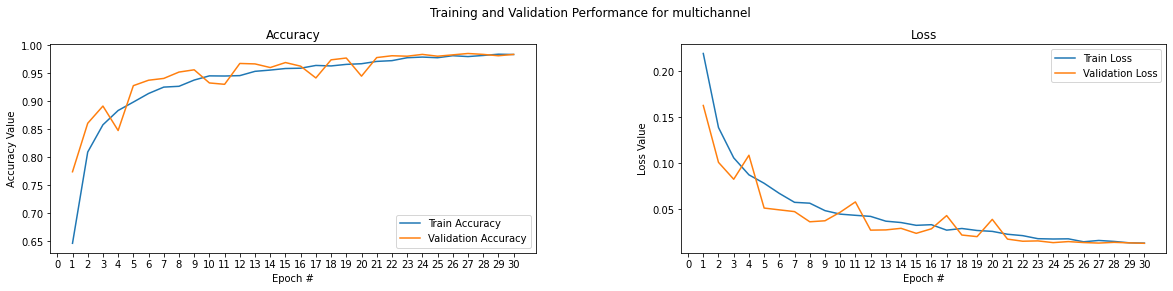

In [12]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance for ' + modelName, fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Prediction

## Store into Arrays

In [ ]:
directory = os.path.join('deepfake_database', 'train_test')
image_format = '.jpg'

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for f in listOfFile:
        if f.endswith(image_format):
            allFiles.append(f)
    return allFiles

def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    return image

In [17]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
from keras.utils import normalize
import cv2

real_data = getListOfFiles(os.path.join(directory, 'real'))
print("No. of Real Images: " + str(len(real_data)))
fake_data = getListOfFiles(os.path.join(directory, 'df'))
print("No. of Fake Images: " + str(len(fake_data)))

rgb_images = []
labels = []

for img in real_data:
    image = preprocess(os.path.join(directory, 'real/') + img)
    rgb_images.append(np.array(image))
    labels.append(1)

for img in fake_data:
    image = preprocess(os.path.join(directory, 'df/') + img)
    rgb_images.append(np.array(image))
    labels.append(0)

labels = np.array(labels)
rgb_images = np.array(rgb_images)

No. of Real Images: 4259
No. of Fake Images: 2845


In [19]:
def splitChannels(image):
    image = cv2.resize(image, (SIZE, SIZE))
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    r, g, b = cv2.split(image)
    return r, g, b

r_images = []
g_images = []
b_images = []

for image in rgb_images:
    r, g, b = splitChannels(image)
    r_images.append(np.array(r))
    g_images.append(np.array(g))
    b_images.append(np.array(b))
r_images = np.array(r_images)
g_images = np.array(g_images)
b_images = np.array(b_images)

'''
bw_images = []
for image in rgb_images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    bw_images.append(np.array(gray))
bw_images = np.array(bw_images)
'''
#rgb_images = rgb_images / 255.0
#bw_images = bw_images / 255.0

'\nbw_images = []\nfor image in rgb_images:\n    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)\n    bw_images.append(np.array(gray))\nbw_images = np.array(bw_images)\n'

## Make Prediction

In [20]:
Y_pred = (model.predict([r_images, g_images, b_images], verbose=1) > 0.5).astype("int32")

import matplotlib.pyplot as plt
predicted_labels = []
count = 0
for pred in Y_pred:
    predicted_labels.append(pred)
predicted_labels = np.array(predicted_labels)

222/222 [==============================] - 1s 5ms/step


## Classification Report

In [21]:
from sklearn.metrics import classification_report
classificationReport = classification_report(labels, predicted_labels, target_names=['df','real'])
print(classificationReport)

              precision    recall  f1-score   support

          df       0.84      0.92      0.88      2845
        real       0.94      0.89      0.91      4259

    accuracy                           0.90      7104
   macro avg       0.89      0.90      0.90      7104
weighted avg       0.90      0.90      0.90      7104



## Confusion Matrix

True positive =  2604
False positive =  241
False negative =  483
True negative =  3776




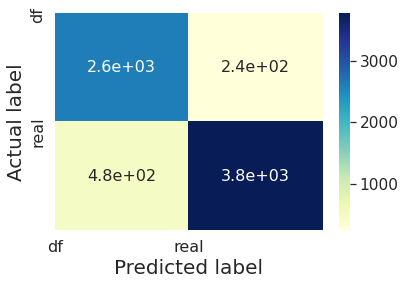

In [22]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['df','real'], size = 16)
    plt.yticks(np.arange(2), ['df','real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    return cm
    
confusionMatrix = print_confusion_matrix(labels, predicted_labels)

# Write to File

In [23]:
import os

tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + str(modelName) + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Image Size: ' + str(SIZE) + '\n' +
    'Epochs: ' + str(EPOCHS) + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' ' + modelName + '.txt')

myFile = open(filename, 'w')
myFile.write(data)
myFile.close()

model.save(modelName + ' ' + datetime_ist.strftime('%Y-%m-%d %H%M') + '.h5')